In [1]:
import os
import sys
import copy
import json
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

from tqdm import tqdm

# Get current working directory and project root directory
cwd = os.getcwd()
rd = os.path.join(cwd.split('stochastic-travel-demand-modelling/', 1)[0])
if not rd.endswith('stochastic-travel-demand-modelling'):
    rd = os.path.join(cwd.split('stochastic-travel-demand-modelling/', 1)[0],'stochastic-travel-demand-modelling')

if rd not in sys.path:
    sys.path.append(rd)

# Import data

In [2]:
constrained = 'singly'

In [3]:
# Import retail data
cost_matrix = np.loadtxt('../data/input/retail/cost_matrix.txt')
origin_supply = np.loadtxt('../data/input/retail/origin_supply.txt')
initial_destination_sizes = np.loadtxt('../data/input/retail/initial_destination_sizes.txt')
rsquared_analysis = np.loadtxt("../cities_and_regions/output/rsquared_analysis.txt")

data = np.loadtxt("../cities_and_regions/data/london_n/shopping_small.txt")
popn = np.loadtxt("../cities_and_regions/data/london_n/popn.txt")
xd = np.loadtxt("../cities_and_regions/data/london_n/xd0.txt")

origin_locs = popn[:, [1, 0]]
destination_locs = data[:, [1, 0]]

mcmc_low_noise_theta_samples_init = np.loadtxt("../cities_and_regions/output/low_noise_samples.txt")
mcmc_low_noise_x_samples_init = np.loadtxt("../cities_and_regions/output/low_noise_samples2.txt")
mcmc_low_noise_sign_samples_init = np.loadtxt("../cities_and_regions/output/low_noise_samples3.txt")

mcmc_high_noise_theta_samples_init = np.loadtxt("../cities_and_regions/output/high_noise_samples.txt")
mcmc_high_noise_x_samples_init = np.loadtxt("../cities_and_regions/output/high_noise_samples2.txt")
mcmc_high_noise_sign_samples_init = np.loadtxt("../cities_and_regions/output/high_noise_samples3.txt")

N,M = cost_matrix.shape

delta = np.min(np.exp(xd))

In [4]:
np.sum(data[:,[2]])

4405709.0

In [5]:
np.sum(origin_supply)

1.0

In [6]:
np.max(rsquared_analysis)

0.9019837895702899

In [7]:
np.min(initial_destination_sizes)

0.00617494255748621

# Sandbox

In [8]:
Ap = np.array([[ 0.00749674, 0.00182529], [ 0.00182529,  0.00709968]])
print(Ap[0,0]/Ap[0,1])
print(Ap[1,0]/Ap[1,1])

4.107150096696963
0.257094685957677


In [9]:
theta_step = 1 #[0.5, 0.02] #0.5
n = 20000
burnin = 0#10000
ideal_theta_ar = 0.45
_print = False

In [10]:
# Proposal and acceptance count
pc = 0
ac = 0

np.random.seed(888)

fake_samples = np.zeros((n,2))
fake_samples[0,:] = mcmc_low_noise_theta_samples_init[0,:]
theta_initial = fake_samples[0,:]
print(f'----- initial theta = {theta_initial} -----')
for i in tqdm(range(n)):

    theta_proposal = theta_initial + theta_step*np.dot(Ap, np.random.normal(0, 1, 2))
    
    for j in range(2):
        if theta_proposal[j] < 0.:
            theta_proposal[j] = -theta_proposal[j]
        elif theta_proposal[j] > 2.:
            theta_proposal[j] = 2. - (theta_proposal[j] - 2.)
        
    pc += 1

    if np.random.uniform(0,1,1) <= ideal_theta_ar:# np.random.uniform(0.4,0.5,1):

#         if _print:
#             print(f'inital theta = {theta_initial}')
#             print(f'theta accepted = {theta_proposal}')

        theta_initial = theta_proposal
        ac += 1
        
#         if _print:
#             print(f'theta AR =  {int(100*ac/pc)}%')
            
    if (i+1) % 1000 == 0:
        if _print:
            print(f'Iteration {i+1}')
            print(f'inital theta = {theta_initial}')
            print(f'theta accepted = {theta_proposal}')
            print(f'theta AR =  {int(100*ac/pc)}%')
        
    fake_samples[i,:] = theta_initial

 17%|█▋        | 3437/20000 [00:00<00:00, 34368.64it/s]

----- initial theta = [1.17097421 0.25761399] -----


100%|██████████| 20000/20000 [00:00<00:00, 41100.50it/s]


In [11]:
1.6880087011673905/1.17097421

1.4415421678393674

In [57]:
0.8255889129130586/0.25761399

3.2047518572770777

RW mean = 1.6880087011673905
RW sd = 0.20124981062145966
RW mean = 0.8255889129130586
RW sd = 0.2894441649013089
mean to sd ration 8.387628768220042
good mean to sd ratio 148.39001212239688


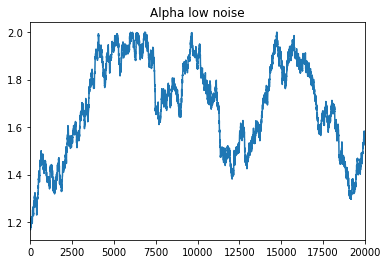

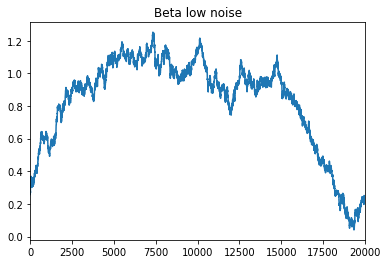

In [12]:
plt.figure(0)
plt.title("Alpha low noise")
print(f'RW mean = {np.mean(fake_samples[burnin:, 0])}')
print(f'RW sd = {np.std(fake_samples[burnin:, 0])}')
plt.plot(fake_samples[burnin:, 0])
plt.xlim([0,n-burnin])

plt.figure(1)
plt.title("Beta low noise")
print(f'RW mean = {np.mean(fake_samples[burnin:, 1])}')
print(f'RW sd = {np.std(fake_samples[burnin:, 1])}')
plt.plot(fake_samples[burnin:, 1])
plt.xlim([0,n-burnin])

print('mean to sd ration', np.mean(fake_samples[burnin:, 0])/np.std(fake_samples[burnin:, 0]))
print('good mean to sd ratio',148.39001212239688)

Alpha ACF


<Figure size 432x288 with 0 Axes>

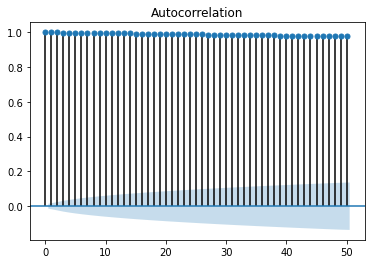

Beta ACF


<Figure size 432x288 with 0 Axes>

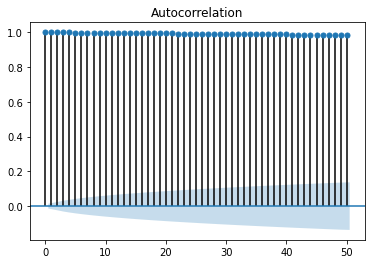

In [55]:
plt.figure(0)
print('Alpha ACF')
sm.graphics.tsa.plot_acf(fake_samples[burnin:,0], lags=50)
plt.show()

plt.figure(1)
print('Beta ACF')
sm.graphics.tsa.plot_acf(fake_samples[burnin:,1], lags=50)
plt.show()

# MCMC initial samples
## Low noise

In [13]:
# Select mcmc start
mcmc_start = 0
n = mcmc_low_noise_theta_samples_init.shape[0]
last_iteration = 10000

RW mean = 1.1746706710157522
RW sd = 0.008053489775221363
RW mean = 0.2612650731130416
RW sd = 0.008173461662774884


(0.0, 10000.0)

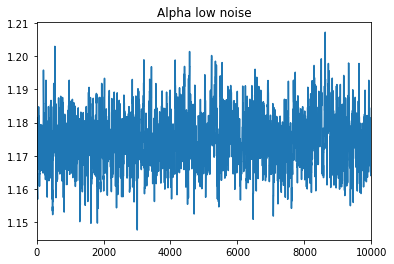

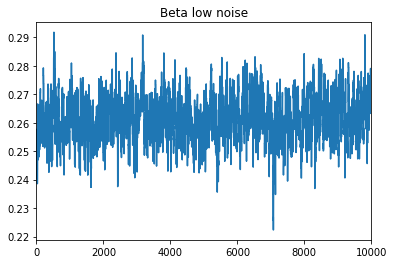

In [14]:
plt.figure(0)
plt.title("Alpha low noise")
print(f'RW mean = {np.mean(mcmc_low_noise_theta_samples_init[mcmc_start:last_iteration, 0])}')
print(f'RW sd = {np.std(mcmc_low_noise_theta_samples_init[mcmc_start:last_iteration, 0])}')
plt.plot(mcmc_low_noise_theta_samples_init[mcmc_start:last_iteration, 0])
plt.xlim([0,last_iteration-mcmc_start])

plt.figure(1)
plt.title("Beta low noise")
print(f'RW mean = {np.mean(mcmc_low_noise_theta_samples_init[mcmc_start:last_iteration, 1])}')
print(f'RW sd = {np.std(mcmc_low_noise_theta_samples_init[mcmc_start:last_iteration, 1])}')
plt.plot(mcmc_low_noise_theta_samples_init[mcmc_start:last_iteration, 1])
plt.xlim([0,last_iteration-mcmc_start])

In [7]:
theta_min = np.min(mcmc_low_noise_theta_samples_init,axis=0)
theta_max = np.max(mcmc_low_noise_theta_samples_init,axis=0)

print('Theta')
print(f'min = {theta_min}')
print(f'max = {theta_max}')

Theta
min = [1.14301849 0.22233999]
max = [1.20727509 0.29199527]


In [8]:
w_min = np.exp(np.min(mcmc_low_noise_x_samples_init,axis=0))
w_max = np.exp(np.max(mcmc_low_noise_x_samples_init,axis=0))

print('X')
print(f'min = {w_min}')
print(f'max = {w_max}')

X
min = [0.20236861 0.02320989 0.01806903 0.02013347 0.016055   0.02258139
 0.01453172 0.01678071 0.0224074  0.01194123 0.01396338 0.02084862
 0.02213392 0.0132242  0.00674286 0.00724915 0.0119439  0.00763987
 0.00717151 0.00771306 0.00918291 0.00799285 0.00697109 0.00766888
 0.01053843 0.00833604 0.00642163 0.00680825 0.00681838 0.00808389
 0.00839645 0.01186566 0.01305519 0.00772339 0.00692581 0.00540522
 0.01206806 0.01016102 0.00716161 0.00656368 0.00937112 0.00918474
 0.01017619 0.01147082 0.00886922 0.00742381 0.00921476 0.00658478
 0.00693617]
max = [0.2920245  0.04652204 0.031625   0.03883611 0.03062416 0.03993206
 0.02884935 0.03233411 0.03609767 0.02051108 0.02578025 0.03462958
 0.04335924 0.02305386 0.01391606 0.01321997 0.02155474 0.01554249
 0.01501998 0.01332051 0.01710376 0.01595043 0.01349164 0.01522357
 0.0212861  0.01626487 0.01374853 0.01309519 0.0144151  0.01570338
 0.01805315 0.02372065 0.02505875 0.01478598 0.0131841  0.01164949
 0.02293799 0.01916731 0.01482649 0

In [88]:
sign_min = np.min(mcmc_low_noise_sign_samples_init,axis=0)
sign_max = np.max(mcmc_low_noise_sign_samples_init,axis=0)

print('X')
print(f'min = {sign_min}')
print(f'max = {sign_max}')

X
min = 1.0
max = 1.0


In [89]:
# Initialisations 
print('theta')
print(mcmc_low_noise_theta_samples_init[:mcmc_start+1])

print('x')
print(mcmc_low_noise_x_samples_init[:mcmc_start+1])
print('true x')
print(xd)

print('sign')
print(mcmc_low_noise_theta_samples_init[:mcmc_start+1])

theta
[[1.17097421 0.25761399]
 [1.17093182 0.25202934]]
x
[[-1.40985754 -3.09458228 -3.48816872 -3.90537175 -3.7423204  -3.48238964
  -3.79974684 -3.43163245 -3.66894133 -4.25558083 -3.91555429 -3.71324914
  -3.19624656 -4.32570667 -4.52965777 -4.61842047 -3.96934135 -4.53634339
  -4.55682268 -4.53580973 -4.36144747 -4.48172112 -4.58625992 -4.57842881
  -4.31459852 -4.55963463 -4.88689429 -4.7928993  -4.68079439 -4.50104671
  -4.50845557 -4.09284085 -4.02958396 -4.55971097 -4.80377157 -4.85345867
  -4.05864181 -4.38481225 -4.65200123 -4.77735801 -4.45483675 -4.50360075
  -4.22594196 -4.11071436 -4.56539446 -4.62870489 -4.49440255 -4.89290679
  -4.68390095]
 [-1.35773336 -3.06782912 -3.68647877 -3.34043021 -3.93426262 -3.61416109
  -3.79156629 -3.95765908 -3.39120472 -4.26572208 -4.07075878 -3.48844623
  -3.63421524 -3.79427778 -4.74829707 -4.70493891 -4.19225328 -4.54362445
  -4.69042757 -4.67386628 -4.33672761 -4.4728943  -4.65694801 -4.65996815
  -4.43418611 -4.69683698 -4.88115673 

## Visualise X initialisations

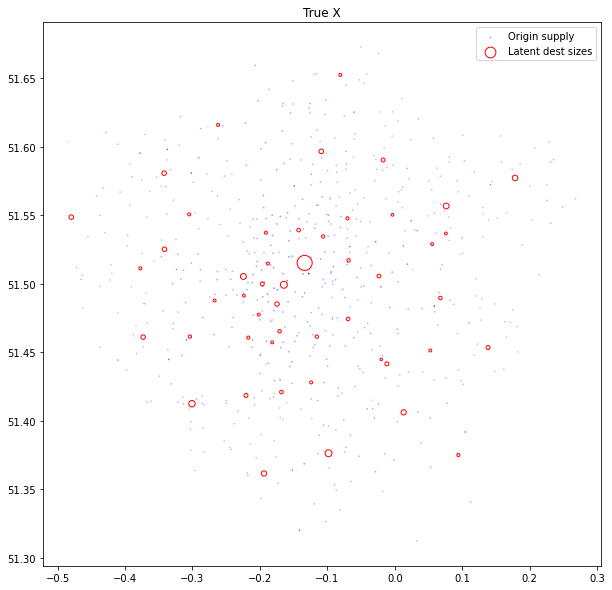

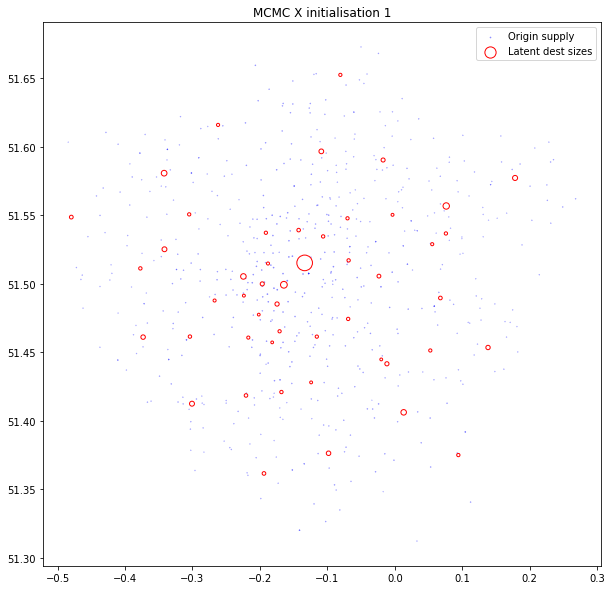

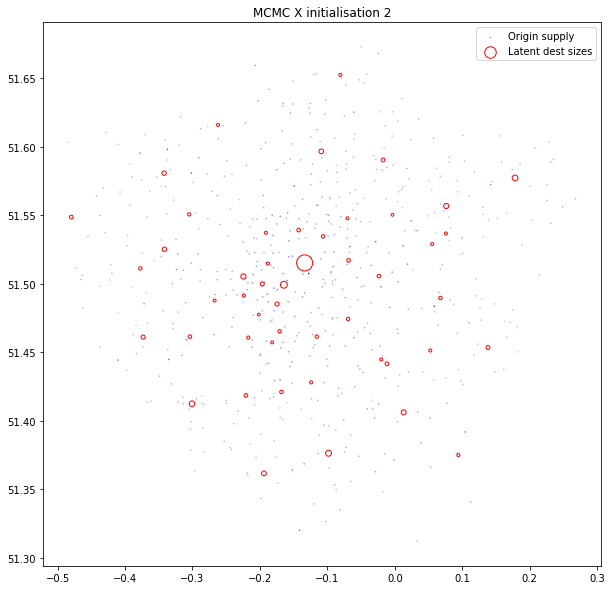

In [90]:
xx1 = mcmc_low_noise_x_samples_init[:mcmc_start+1][0]
xx2 = mcmc_low_noise_x_samples_init[:mcmc_start+1][1]

plt.figure(0,figsize=(10,10))
plt.title("True X")
plt.scatter(origin_locs[:, 1], origin_locs[:, 0], color='w',edgecolors='b',s=100*origin_supply, alpha=0.5,label='Origin supply')
plt.scatter(destination_locs[:, 1], destination_locs[:, 0], color='w',edgecolors='r', s=1000*np.exp(xd),label='Latent dest sizes')
plt.legend()

plt.figure(1,figsize=(10,10))
plt.title("MCMC X initialisation 1")
plt.scatter(origin_locs[:, 1], origin_locs[:, 0], color='w',edgecolors='b',s=100*origin_supply, alpha=0.5,label='Origin supply')
plt.scatter(destination_locs[:, 1], destination_locs[:, 0], color='w',edgecolors='r', s=1000*np.exp(xx1),label='Latent dest sizes')
plt.legend()

plt.figure(2,figsize=(10,10))
plt.title("MCMC X initialisation 2")
plt.scatter(origin_locs[:, 1], origin_locs[:, 0], color='w',edgecolors='b',s=100*origin_supply, alpha=0.5,label='Origin supply')
plt.scatter(destination_locs[:, 1], destination_locs[:, 0], color='w',edgecolors='r', s=1000*np.exp(xx2),label='Latent dest sizes')
plt.legend()

## Final samples

In [ ]:
mcmc_low_noise_theta_samples = np.loadtxt(f"../data/output/retail/{constrained}_low_noise_theta_samples.txt")
mcmc_low_noise_x_samples = np.loadtxt(f"../data/output/retail/{constrained}_low_noise_logsize_samples.txt")
mcmc_low_noise_sign_samples = np.loadtxt(f"../data/output/retail/{constrained}_low_noise_sign_samples.txt")

In [15]:
# Select mcmc start
mcmc_start = 0
n = mcmc_low_noise_theta_samples_init.shape[0]
last_iteration = 10000

RW mean = 1.1746706710157522
RW sd = 0.008053489775221363
RW mean = 0.2612650731130416
RW sd = 0.008173461662774884


(0.0, 10000.0)

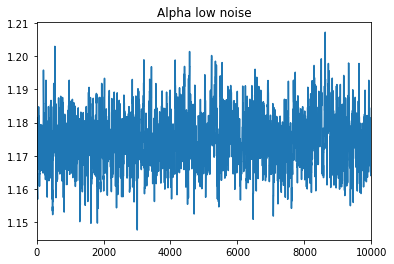

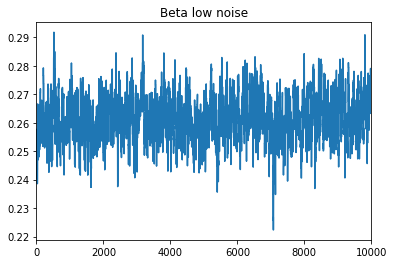

In [16]:
plt.figure(0)
plt.title("Alpha low noise")
print(f'RW mean = {np.mean(mcmc_low_noise_theta_samples_init[mcmc_start:last_iteration, 0])}')
print(f'RW sd = {np.std(mcmc_low_noise_theta_samples_init[mcmc_start:last_iteration, 0])}')
plt.plot(mcmc_low_noise_theta_samples_init[mcmc_start:last_iteration, 0])
plt.xlim([0,last_iteration-mcmc_start])

plt.figure(1)
plt.title("Beta low noise")
print(f'RW mean = {np.mean(mcmc_low_noise_theta_samples_init[mcmc_start:last_iteration, 1])}')
print(f'RW sd = {np.std(mcmc_low_noise_theta_samples_init[mcmc_start:last_iteration, 1])}')
plt.plot(mcmc_low_noise_theta_samples_init[mcmc_start:last_iteration, 1])
plt.xlim([0,last_iteration-mcmc_start])

In [17]:
theta_min = np.min(mcmc_low_noise_theta_samples_init,axis=0)
theta_max = np.max(mcmc_low_noise_theta_samples_init,axis=0)

print('Theta')
print(f'min = {theta_min}')
print(f'max = {theta_max}')

Theta
min = [1.14301849 0.22233999]
max = [1.20727509 0.29199527]


## High noise

In [91]:
# Select mcmc start
mcmc_start = 10000

In [93]:
# Import Laplace optimal for high noise regime
with open(f'../data/output/retail/laplace/figures/{constrained}_laplace_analysis_gamma_100_parameters.json') as json_file:
    laplace_high_noise_opt_params = json.load(json_file)
    
alpha_opt = laplace_high_noise_opt_params['fitted_alpha']
beta_opt = laplace_high_noise_opt_params['fitted_scaled_beta']

print('alpha = ',alpha_opt,' beta = ',beta_opt)

alpha =  0.9  beta =  0.44


In [94]:
theta_min = np.min(mcmc_high_noise_theta_samples_init[:mcmc_start+1],axis=0)
theta_max = np.max(mcmc_high_noise_theta_samples_init[:mcmc_start+1],axis=0)
theta_mean = np.mean(mcmc_high_noise_theta_samples_init[:mcmc_start+1],axis=0)

print('Theta')
print(f'min = {theta_min}')
print(f'max = {theta_max}')
print(f'mean = {theta_mean}')
print(f'initial = {mcmc_high_noise_theta_samples_init[mcmc_start]}')

Theta
min = [0.00012304 0.00309509]
max = [1.99572883 1.99978564]
mean = [0.44971714 1.07697206]
initial = [0.80559407 1.3256266 ]


In [96]:
w_min = np.exp(np.min(mcmc_high_noise_x_samples_init,axis=0))
w_max = np.exp(np.max(mcmc_high_noise_x_samples_init,axis=0))

print('X')
print(f'min = {w_min}')
print(f'max = {w_max}')

X
min = [0.13211871 0.0312635  0.01811604 0.03259764 0.01292458 0.02391923
 0.01495846 0.01404828 0.02032237 0.01328183 0.01303821 0.02800019
 0.0216646  0.01872564 0.00518055 0.00623687 0.01021743 0.00633026
 0.00639565 0.00599274 0.00906814 0.00614914 0.00630418 0.005769
 0.00797353 0.00681986 0.00567402 0.00502316 0.00600319 0.00734764
 0.00788788 0.01059206 0.0131288  0.00793823 0.00611551 0.0042321
 0.01028214 0.0102863  0.00583727 0.00495913 0.00734526 0.00881522
 0.00929372 0.01081862 0.00797164 0.00648909 0.00889923 0.00530855
 0.00565312]
max = [0.29292454 0.08246185 0.04327237 0.0738683  0.03111739 0.05056298
 0.03188047 0.02999866 0.0440603  0.0317088  0.02861042 0.06272995
 0.04946849 0.04089231 0.01232539 0.01340648 0.02321926 0.01462761
 0.01326829 0.01400977 0.01864207 0.01383252 0.01420177 0.01282041
 0.0189705  0.01581413 0.01215735 0.01235577 0.01305362 0.01565111
 0.01683775 0.02302213 0.02937399 0.01745348 0.01287221 0.00939215
 0.02346347 0.02283377 0.01245011 0.01

In [97]:
sign_min = np.min(mcmc_high_noise_sign_samples_init,axis=0)
sign_max = np.max(mcmc_high_noise_sign_samples_init,axis=0)

print('X')
print(f'min = {sign_min}')
print(f'max = {sign_max}')

X
min = -1.0
max = 1.0


In [112]:
# Initialisations 
print('theta')
print(mcmc_high_noise_theta_samples_init[mcmc_start])

print('x')
print(mcmc_high_noise_x_samples_init[mcmc_start])
print('true x')
print(xd)

theta
[0.80559407 1.3256266 ]
x
[-1.54978513 -2.85979709 -3.68803163 -3.16654447 -3.78508629 -3.47685786
 -3.75351336 -3.83097468 -3.49223374 -3.99034077 -3.97075263 -3.17169465
 -3.28575879 -3.51291831 -4.74237918 -4.75390314 -4.23693284 -4.78363312
 -4.67910919 -4.77796943 -4.3582827  -4.77696291 -4.67115698 -4.75361927
 -4.31932983 -4.62942587 -4.6668435  -4.78334789 -4.70379904 -4.64469
 -4.46424076 -4.05202993 -3.91495654 -4.53229587 -4.63810602 -5.27154259
 -4.0984798  -4.12893253 -4.90506314 -4.9763746  -4.7115091  -4.46840667
 -4.29581322 -4.20205655 -4.60237697 -4.57228272 -4.4579995  -4.82376312
 -4.6952996 ]
true x
[-1.48623058 -3.03561986 -3.58171342 -3.03525569 -3.87291895 -3.34915369
 -3.82990594 -3.90168635 -3.48825664 -3.87325777 -3.92661348 -3.17789396
 -3.40539764 -3.57490902 -4.86212472 -4.70632978 -4.17330661 -4.68831218
 -4.71656632 -4.68358147 -4.35330522 -4.67804156 -4.66047408 -4.76948955
 -4.43912399 -4.6066787  -4.8085742  -4.84311755 -4.74705539 -4.53253984
 

## Visualise X initialisations

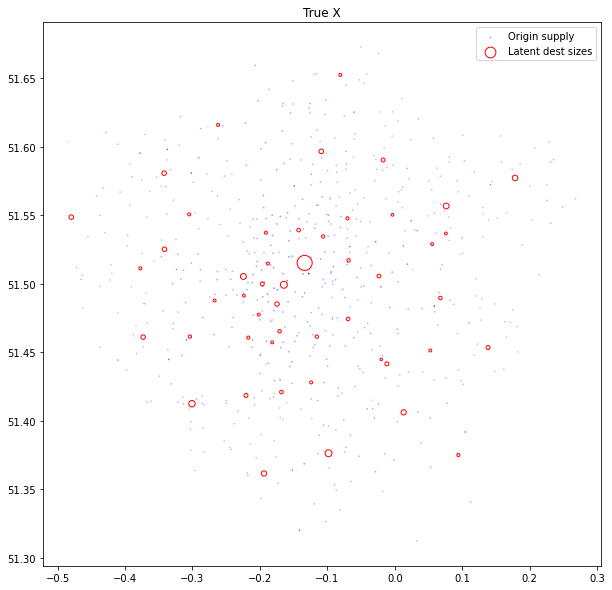

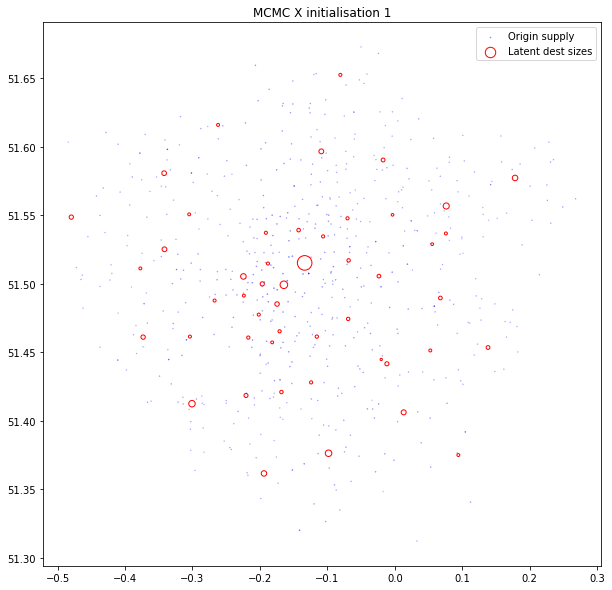

In [115]:
xx = mcmc_high_noise_x_samples_init[mcmc_start]

plt.figure(0,figsize=(10,10))
plt.title("True X")
plt.scatter(origin_locs[:, 1], origin_locs[:, 0], color='w',edgecolors='b',s=100*origin_supply, alpha=0.5,label='Origin supply')
plt.scatter(destination_locs[:, 1], destination_locs[:, 0], color='w',edgecolors='r', s=1000*np.exp(xd),label='Latent dest sizes')
plt.legend()

plt.figure(1,figsize=(10,10))
plt.title("MCMC X initialisation 1")
plt.scatter(origin_locs[:, 1], origin_locs[:, 0], color='w',edgecolors='b',s=100*origin_supply, alpha=0.5,label='Origin supply')
plt.scatter(destination_locs[:, 1], destination_locs[:, 0], color='w',edgecolors='r', s=1000*np.exp(xx),label='Latent dest sizes')
plt.legend()

# MCMC samples

## Low noise

In [ ]:
samples = np.loadtxt(os.path.join(rd,f"data/output/retail/inverse_problem/{constrained}_low_noise_theta_samples.txt"))
samples2 = np.loadtxt(os.path.join(rd,f"data/output/retail/inverse_problem/{constrained}_low_noise_logsize_samples.txt"))
samples3 = np.loadtxt(os.path.join(rd,f"data/output/retail/inverse_problem/{constrained}_low_noise_sign_samples.txt"))


In [ ]:
np.mean(samples,axis=0)

In [ ]:
posterior_xd = np.mean(samples2,axis=0)

In [ ]:
np.exp(posterior_xd)

In [ ]:
np.exp(xd)

In [ ]:
plt.scatter(posterior_xd,xd)

In [ ]:
np.corrcoef(posterior_xd,xd)[0,1]

In [ ]:
plt.hist(samples)

In [ ]:
sm.graphics.tsa.plot_acf(samples[:,0], lags=50)
plt.show()

In [ ]:
sm.graphics.tsa.plot_acf(samples[:,1], lags=50)
plt.show()

# High noise

In [46]:
np.mean(mcmc_high_noise_theta_samples_init,axis=0)

array([0.45206115, 1.06741012])

In [ ]:
posterior_xd = np.mean(mcmc_high_noise_x_samples_init,axis=0)

In [ ]:
np.exp(posterior_xd)

In [ ]:
np.exp(xd)

In [ ]:
plt.scatter(posterior_xd,xd)

In [ ]:
np.corrcoef(posterior_xd,xd)[0,1]

In [ ]:
plt.hist(mcmc_high_noise_theta_samples_init,bins=100)

In [ ]:
mcmc_high_noise_x_samples_init.shape

In [ ]:
sm.graphics.tsa.plot_acf(mcmc_high_noise_theta_samples_init[:,0], lags=50)
plt.show()

In [ ]:
sm.graphics.tsa.plot_acf(mcmc_high_noise_x_samples_init[:,1], lags=50)
plt.show()

# Retail data

## Import retail data

In [ ]:
data = np.loadtxt("../cities_and_regions/data/london_n/shopping_small.txt")
popn = np.loadtxt("../cities_and_regions/data/london_n/popn.txt")
retail_wd0 = np.exp(np.loadtxt("../cities_and_regions/data/london_n/xd0.txt"))
retail_orig_supply = popn[:, 2]/popn[:, 2].sum()
ret_locs = data[:, [0, 1]]
res_locs = popn[:, [0, 1]]

## Plot retail data

In [ ]:
# Set plot params
latent_factor = 1000
actual_factor = 10000

In [ ]:
plt.figure(figsize=(20,20))
plt.scatter(ret_locs[:, 1], ret_locs[:, 0], facecolor="None",edgecolors='b', s=actual_factor*retail_wd0, alpha=1,label='Dest sizes')
plt.scatter(res_locs[:, 1], res_locs[:, 0], facecolor="None",edgecolors='g', s=actual_factor*retail_orig_supply, alpha=1,label='Orig supply')
# Plot legend.
lgnd = plt.legend(loc="upper right", scatterpoints=1, fontsize=10)
lgnd.legendHandles[0]._sizes = [30]
lgnd.legendHandles[1]._sizes = [30]